In [417]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.autograd import Variable
from pymongo import MongoClient
from datetime import datetime

def _connect_mongo(host, port, username, password, db):
    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)
        
    return conn[db]

def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    db =_connect_mongo(db=db, host=host, port=port, username=username, password=password)
    cursor = db[collection].find(query)
        
    return list(cursor)

def _build_vector(event):
    # vector_len = 290
    # f_vector = np.zeros(vectror_len)
    
    m_country = assign_country_mapper()
    m_event = assign_event_type_mapper()
    m_agent_os = assign_agent_os_mapper()
    m_agent_name = assign_agent_name_mapper()
    
    f_vector_evty = np.zeros(4)
    f_vector_evty[m_event[event['type']]] = 1
    
    
    dt = datetime.utcfromtimestamp(event['timestamp'])
    minutes = (dt.hour * 60) + dt.minute
    day = dt.weekday()
    f_vector_dt = np.zeros(2)
    f_vector_dt[0] = round(minutes / 1439, 5)
    f_vector_dt[1] = round(day / 6, 5)
    
    latitude = event['geoip']['latitude'][0]
    longitude = event['geoip']['longitude'][0]
    f_vector_geo = np.zeros(2)
    f_vector_geo[0]= round((latitude + 90) / 180,5)
    f_vector_geo[1]= round((longitude + 180) / 360, 5)
    
    f_vector_agos = np.zeros(8)
    os = event['agent']['os'][0]
    if os in m_agent_os:
        f_vector_agos[m_agent_os[os]] = 1
    else:
        f_vector_agos[-1] = 1
        
    f_vector_agna = np.zeros(26)
    name = event['agent']['name'][0]
    if name in m_agent_name:
        f_vector_agna[m_agent_name[name]] = 1
    else:
        f_vector_agna[-1] = 1
        
    f_vector_country = np.zeros(248)
    country = event['geoip']['country'][0]
    if country in m_country:
        f_vector_country[m_country[country]] = 1
    else:
        f_vector_country[-1] = 1
    
    # without geo and without country features
    # return np.concatenate([f_vector_evty, f_vector_dt, f_vector_agos, f_vector_agna])

    # without country feature
    # return np.concatenate([f_vector_evty, f_vector_dt, f_vector_geo, f_vector_agos, f_vector_agna])
    
    # all features
    return np.concatenate([f_vector_evty, f_vector_dt, f_vector_geo, f_vector_agos, f_vector_agna, f_vector_country])

def vectorize(json):
    events = sorted(np.concatenate([json['connects'], json['plays'], json['h5liveStats'],json['closes']]), key=lambda d: d['timestamp'])
    vector_list = []
    if len(events) == 0:
        return None
    for event in events:
        vector_list.append(_build_vector(event))
    return np.stack(vector_list)

def add_event_types(json):
    if 'rtmpStats' in json:
        rtmpStats = json['rtmpStats']
        for x in rtmpStats:
            x['type']='rtmp'
    
    if 'connects' in json:
        connects = json['connects'] 
        for x in connects:
            x['type']='connect'
        
    if 'plays' in json:
        plays = json['plays']
        for x in plays:
            x['type']='play'
            
    if 'h5liveStats' in json:
        h5liveStats = json['h5liveStats']
        for x in h5liveStats:
            x['type']='h5live'
    
    if 'closes' in json:
        closes = json['closes']
        for x in closes:
            x['type']='close'  
    
    return json

In [58]:
import json

def assign_country_mapper():
    with open('../../src/util/country_mapper.json') as f:
        d = json.load(f)
        return d

def assign_event_type_mapper():
    with open('../../src/util/event_type_mapper.json') as f:
        d = json.load(f)
        return d
    
def assign_agent_os_mapper():
    with open('../../src/util/agent_os_mapper.json') as f:
        d = json.load(f)
        return d
    
def assign_agent_name_mapper():
    with open('../../src/util/agent_name_mapper.json') as f:
        d = json.load(f)
        return d

In [59]:
# load data from MongoDB
misuses = read_mongo('dataset1', 'misuse_data')
regulars = read_mongo('dataset1', 'regular_data')

In [418]:
v_misuses = []
v_regulars = []

for x in misuses:
    x = add_event_types(x)
    y = vectorize(x)
    if y is not None:
        # print(y.shape)
        v_misuses.append(y)

for x in regulars:
    x = add_event_types(x)
    y = vectorize(x)
    if y is not None:
        # print(y.shape)
        v_regulars.append(y)

print('Misuses: ' + str(len(misuses)), 'Regulars: ' + str(len(regulars)))
print('Valid Misuses: ' + str(len(v_misuses)), 'Valid Regulars: ' + str(len(v_regulars)))

Misuses: 214 Regulars: 638
Valid Misuses: 214 Valid Regulars: 512


In [419]:
train_size = (144,496)
im = torch.tensor([[1,0], [0,1]])

X_train_misuse = v_misuses[:train_size[0]:1]
X_train_regular = v_regulars[:train_size[1]:1]
X_train_final = X_train_misuse + X_train_regular

y_train = np.zeros_like(list(range(len(X_train_final))))

for i in range(len(y_train)):
    if i >= len(X_train_misuse):
        y_train[i] = 1

max_length_training = max([arr.shape[0] for arr in X_train_final])
padded_train_data = np.array([np.pad(arr,((0, max_length_training - arr.shape[0]), (0,0)), mode='constant') for arr in X_train_final])

tensor_train_data = Variable(torch.tensor(padded_train_data, dtype=torch.float64))
tensor_train_labels = Variable(im[torch.tensor(y_train)])


X_test_misuse = v_misuses[train_size[0]::1]
X_test_regular = v_regulars[train_size[1]::1]
X_test_final = X_test_misuse + X_test_regular

y_test = np.zeros_like(list(range(len(X_test_final))))

for i in range(len(y_test)):
    if i >= len(X_test_misuse):
        y_test[i] = 1

max_length_testing = max([arr.shape[0] for arr in X_test_final])
padded_test_data = np.array([np.pad(arr,((0, max_length_testing - arr.shape[0]), (0,0)), mode='constant') for arr in X_test_final])

tensor_test_data = Variable(torch.tensor(padded_test_data, dtype=torch.float64))
tensor_test_labels = Variable(im[torch.tensor(y_test)])

print('Training: ', tensor_train_data.shape, ' ', tensor_train_labels.shape)
print('Testing: ', tensor_test_data.shape, ' ', tensor_test_labels.shape)

Training:  torch.Size([640, 4000, 290])   torch.Size([640, 2])
Testing:  torch.Size([86, 3300, 290])   torch.Size([86, 2])


In [486]:
input_size = tensor_train_data.shape[2]
hidden_size = 16
num_layers = 1
num_classes = 2
num_epochs = 10
learning_rate = 0.025
batch_size = 16

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, seq_length):
        super(LSTMClassifier, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, num_classes)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.soft = nn.Softmax()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        lstm_out, (hn, cn) = self.lstm(x, (h_0, c_0))

        # use last output of the last lstm layer
        out = lstm_out[:, -1, :]

        out = self.relu(out)

        self.dropout = nn.Dropout(p=0.2)
        #out = self.relu(out)
        # first fully connected layer
        out = self.fc1(out)

        # second fully connected layer
        #out = self.fc2(out)

        # third fully connected layer
        #out = self.fc3(out)
        
        out = torch.sigmoid(out)

        return out


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes, tensor_train_data.shape[0]).to(device)

# loss_func = torch.nn.MSELoss()
# loss_func = torch.nn.CrossEntropyLoss()
loss_func = torch.nn.BCELoss()

import torch.optim as optim

# Definition des Optimizers mit Lernrate lr
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


#define for filename
num_fclayers = 1
last_func = 'sig'
l_func = 'BCE'

In [487]:
logging = True
filename = 'r'+ str(num_layers)+ '_f'+ str(num_fclayers)+ '_'+ last_func+ '_h'+ str(hidden_size)+ '_b'+ str(batch_size)+ '_l'+ str(learning_rate)+ '_e'+ str(num_epochs) 
filepath = "./results/" +filename+".txt"
if logging:
    with open(filepath, 'w') as f:
        f.write('Start logging loss' + '\n')

losses = []

# set train mode 
model.train()

# Training loop
total_step = len(tensor_train_data) // batch_size
for epoch in range(num_epochs):
    batch_index_list = list(range(total_step))
    for i in range(0, len(tensor_train_data), batch_size):
        
        ran_index = random.choice(batch_index_list)
        print(ran_index)
        batch_index_list.remove(ran_index)
        # Mini-batch data
        batch_inputs = tensor_train_data[ran_index:ran_index+batch_size, :, :].float()
        batch_labels = tensor_train_labels[ran_index:ran_index+batch_size]
        
        
        # Forward pass
        outputs = model.forward(batch_inputs)
        loss = loss_func(outputs.float(), batch_labels.float())
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

        # Print statistics (adjust to modolu)
        if (i+1) % 1 == 0:
            message = 'Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i//batch_size+1, total_step, loss.item())
            print(message)
            if logging:
                # log results
                with open(filepath, 'a') as f:
                    f.write(message+'\n')

28
Epoch [1/10], Batch [1/40], Loss: 0.6216
37
Epoch [1/10], Batch [2/40], Loss: 0.6186
3
Epoch [1/10], Batch [3/40], Loss: 0.6153
7
Epoch [1/10], Batch [4/40], Loss: 0.6124
12
Epoch [1/10], Batch [5/40], Loss: 0.6098
38
Epoch [1/10], Batch [6/40], Loss: 0.6070
8
Epoch [1/10], Batch [7/40], Loss: 0.6038
14
Epoch [1/10], Batch [8/40], Loss: 0.6012
33
Epoch [1/10], Batch [9/40], Loss: 0.5984
1
Epoch [1/10], Batch [10/40], Loss: 0.5953
27
Epoch [1/10], Batch [11/40], Loss: 0.5928
34
Epoch [1/10], Batch [12/40], Loss: 0.5901
20
Epoch [1/10], Batch [13/40], Loss: 0.5873
0
Epoch [1/10], Batch [14/40], Loss: 0.5842
9
Epoch [1/10], Batch [15/40], Loss: 0.5819
4
Epoch [1/10], Batch [16/40], Loss: 0.5788
30
Epoch [1/10], Batch [17/40], Loss: 0.5765
18
Epoch [1/10], Batch [18/40], Loss: 0.5739
2
Epoch [1/10], Batch [19/40], Loss: 0.5709
36
Epoch [1/10], Batch [20/40], Loss: 0.5686
35
Epoch [1/10], Batch [21/40], Loss: 0.5660
22
Epoch [1/10], Batch [22/40], Loss: 0.5634
25
Epoch [1/10], Batch [23/

In [490]:
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    outputs = model.forward(tensor_test_data.float())
    _, predicted = torch.max(outputs, dim=1)
    total_samples += tensor_test_labels.size(0)
    total_correct += (predicted == torch.argmax(tensor_test_labels, dim=1)).sum().item()

test_accuracy = total_correct / total_samples
print(f"Test accuracy: {test_accuracy:.3f}" + f' Correct: {total_correct}' +' of '+ f'{total_samples}')

Test accuracy: 0.814 Correct: 70 of 86


In [414]:
outputs[78]

tensor([0.9932, 0.0109])

In [477]:
sig = losses

In [488]:
soft = losses

In [283]:
epoch = losses

/var/folders/f6/qs32bx3d27b9m0rzlgsy27bh0000gn/T/ipykernel_26019/3250584558.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x1, y1, 'y', label='Sigmoid SGD / 81,4%', color="red")
/var/folders/f6/qs32bx3d27b9m0rzlgsy27bh0000gn/T/ipykernel_26019/3250584558.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x2, y2, 'y', label='Sigmoid SGD + Dropout / 81,4%', color="blue")


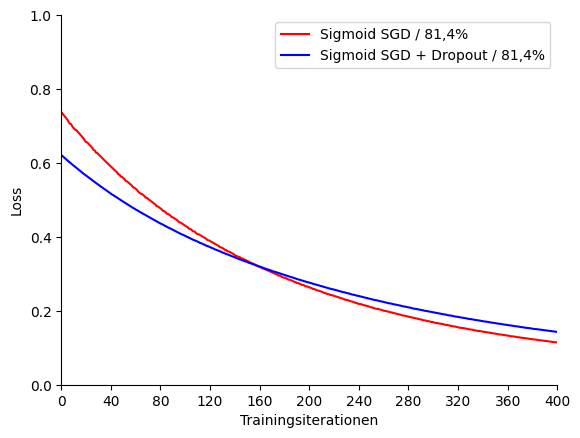

In [491]:
import matplotlib.pyplot as plt
import numpy as np
  
x_base = 400
x_range = range(x_base)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# ax.spines['left'].set_position('center')
# ax.spines['bottom'].set_position(0.5)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xlim(left=0, right=x_base)
ax.set_ylim(bottom=0, top=1)

plt.xticks(range(min(x_range), max(x_range)+2)[::40])

x1 = range(len(sig))
x2 = range(len(soft))
x3 = range(40)

y1 = sig
y2 = soft
y3 = epoch

plt.plot(x1, y1, 'y', label='Sigmoid SGD / 81,4%', color="red")
plt.plot(x2, y2, 'y', label='Sigmoid SGD + Dropout / 81,4%', color="blue")
# plt.plot(x3, y3, 'y', label='1 Epoche', color="orange")

plt.xlabel('Trainingsiterationen', fontsize=10, fontweight='regular', color='black')
plt.ylabel('Loss', fontsize=10, fontweight='regular', color='black')

plt.legend(loc='upper right')
plt.show()